## Comparison between original FX, Impulse Response and AI emulation

This Jupyter Notebook aims to compare the original fx results with the IR emulation and IA emulation results for each FX. The metrics used for comparison are described in this file.

In [1]:
import matplotlib.pyplot as plt
import json
import librosa
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
from pathlib import Path
from numpy import random
from IPython.display import Audio

In [2]:
def calculate_cosine_similarity(original_fx_dataset_path_fn, ir_dataset_path_fn, fx_fn, samplerate_fn, n_mfccs_fn, hop_length_fn):
    def yield_metric_each_audio():
        for audio_fx_path in (original_fx_dataset_path_fn/fx_fn).iterdir():   
            audio_name    = audio_fx_path.name
            audio_ir_path = ir_dataset_path_fn/fx_fn/audio_name
            
            y_fx, _ = librosa.load(audio_fx_path, sr=samplerate_fn)
            y_ir, _ = librosa.load(audio_ir_path, sr=samplerate_fn)

            mfcc_fx = librosa.feature.mfcc(y=y_fx, sr=samplerate_fn, n_mfcc=n_mfccs_fn, hop_length=hop_length_fn)
            mfcc_ir = librosa.feature.mfcc(y=y_ir, sr=samplerate_fn, n_mfcc=n_mfccs_fn, hop_length=hop_length_fn)

            cosine_sim = cosine_similarity(mfcc_fx.reshape(1, -1), mfcc_ir.reshape(1, -1))[0][0]
            yield cosine_sim
    return fx_fn, list(yield_metric_each_audio())

In [3]:
original_fx_dataset_path = Path('../datasets/guitar_chords_v2/fx/audio_files/')
ir_dataset_path          = Path('../datasets/guitar_chords_v2/impulse_response_emulation/audio_files/')
ai_dataset_path          = Path('../datasets/guitar_chords_v2/fx/audio_files/') # change for ai/audio_files/ later
fx_parameters_path       = Path('../datasets/guitar_chords_v2/fx/parameters.json')
fx_parameters            = json.load(open(fx_parameters_path))
lst_fx                   = list(fx_parameters['fx'].keys())
samplerate               = 16000
n_mfccs                  = 20
window_time_sec          = 0.2
hop_length               = int(window_time_sec * samplerate)

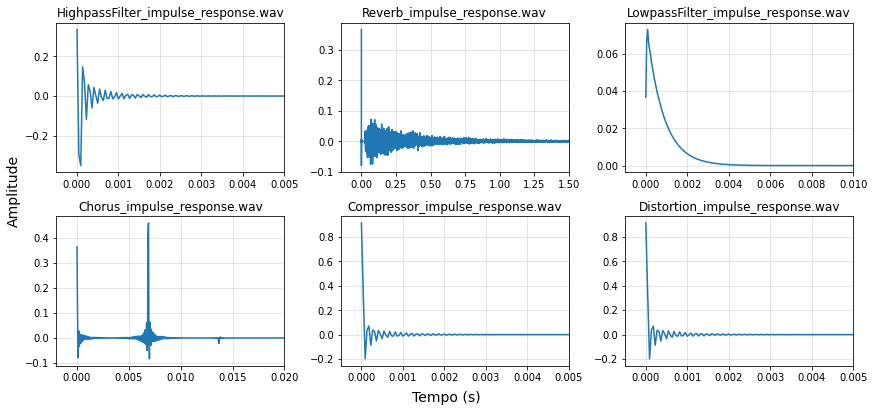

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

dict_x_lims = {
    'HighpassFilter_impulse_response.wav': [-0.0005, 0.005],
    'Reverb_impulse_response.wav':         [-0.1500, 1.500],
    'LowpassFilter_impulse_response.wav':  [-0.0010, 0.010],
    'Chorus_impulse_response.wav':         [-0.0020, 0.020],
    'Compressor_impulse_response.wav':     [-0.0005, 0.005],
    'Distortion_impulse_response.wav':     [-0.0005, 0.005],
}

for i_fig, ir_audio_path in enumerate(ir_dataset_path.glob('*.wav')):
    i     = 0 if i_fig < 3 else 1
    j     = i_fig - 3 if i else i_fig
    y, sr = librosa.load(ir_audio_path)
    axs[i, j].plot(np.arange(len(y))/sr, y)
    axs[i, j].set_title(ir_audio_path.name)
    axs[i, j].grid(alpha=0.4)
    axs[i, j].set_xlim(dict_x_lims.get(ir_audio_path.name))

fig.text(0.5, 0.02, 'Tempo (s)', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../results/ir_audios_plot_in_time.pdf', bbox_inches='tight')
plt.show()


In [4]:
cosine_sim_results = Parallel(n_jobs=-1, verbose=100)(
    delayed(calculate_cosine_similarity)(
        original_fx_dataset_path, 
        ir_dataset_path, 
        fx, 
        samplerate, 
        n_mfccs, 
        hop_length
    ) for fx in lst_fx
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    5.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    5.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s finished


In [13]:
fig_name = 'mfcc_cosine_similarity_box_plot'
fig      = go.Figure()

for i, cos_sim_result in enumerate(cosine_sim_results):
    fig.add_box(
        x    = np.ones(len(cos_sim_result[1])) * i,
        y    = cos_sim_result[1],
        name = cos_sim_result[0]
    )

fig.update_layout(
    width       = 600,
    height      = 300,
    yaxis_title = 'MFCC Cosine Similarity',
    showlegend  = False,
    xaxis       = dict(
        tickvals= np.arange(0, len(lst_fx)),
        ticktext= lst_fx
    )
    
)

fig.write_image('../results/{}.pdf'.format(fig_name))
fig.show()

In [6]:
dict_results_summary = dict()
for cos_sim_result in cosine_sim_results:
    dict_results_summary[cos_sim_result[0]]           = dict()
    dict_results_summary[cos_sim_result[0]]['Mean']   = float(np.mean(cos_sim_result[1]))
    dict_results_summary[cos_sim_result[0]]['Median'] = float(np.median(cos_sim_result[1]))
    dict_results_summary[cos_sim_result[0]]['Min']    = float(np.min(cos_sim_result[1]))
    dict_results_summary[cos_sim_result[0]]['Max']    = float(np.max(cos_sim_result[1]))
    dict_results_summary[cos_sim_result[0]]['Var']    = float(np.var(cos_sim_result[1]))
    dict_results_summary[cos_sim_result[0]]['Std']    = float(np.std(cos_sim_result[1]))

with open('../results/{}.json'.format(fig_name), mode='w') as f:
    json.dump(dict_results_summary, f, indent=4)

print(json.dumps(dict_results_summary, indent=4))

{
    "Compressor": {
        "Mean": 0.9962714910507202,
        "Median": 0.9972684383392334,
        "Min": 0.9819505214691162,
        "Max": 0.9999945759773254,
        "Var": 1.0293249033566099e-05,
        "Std": 0.0032083094120025635
    },
    "Chorus": {
        "Mean": 0.9994907379150391,
        "Median": 0.9996083378791809,
        "Min": 0.9970743060112,
        "Max": 0.9998932480812073,
        "Var": 1.7113357841935795e-07,
        "Std": 0.0004136829520575702
    },
    "Distortion": {
        "Mean": 0.9790134429931641,
        "Median": 0.9825913310050964,
        "Min": 0.9176267981529236,
        "Max": 0.9974168539047241,
        "Var": 0.00026292441179975867,
        "Std": 0.016214944422245026
    },
    "Reverb": {
        "Mean": 0.9999936819076538,
        "Median": 0.999997615814209,
        "Min": 0.9999362230300903,
        "Max": 1.0,
        "Var": 9.377992826742343e-11,
        "Std": 9.684003998700064e-06
    },
    "LowpassFilter": {
        "Mean": 